In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import glob, os
import sys


In [2]:
columns = ['YEAR','MONTH','DAY','TEMP_HIG','TEMP_COL','AVG_TEMP','AVG_WET','DATA_COL']
data = pd.read_csv('1.csv',names=columns)
data

,YEAR,MONTH,DAY,TEMP_HIG,TEMP_COL,AVG_TEMP,AVG_WET,DATA_COL
0,2015,2,1,1.9,-0.4,0.7875,75.000,907.177044
1,2015,2,2,6.2,-3.9,1.7625,77.250,747.835779
2,2015,2,3,7.8,2.0,4.2375,72.750,740.097015
3,2015,2,4,8.5,-1.2,3.0375,65.875,760.081199
4,2015,2,5,7.9,-3.6,1.8625,55.375,676.920858
...,...,...,...,...,...,...,...,...
573,2016,8,27,27.8,19.2,23.1375,63.875,405.774864
574,2016,8,28,29.9,16.1,23.3125,68.500,424.654201
575,2016,8,29,29.9,18.1,23.7125,62.500,440.166755
576,2016,8,30,29.3,16.9,23.3250,71.500,425.353283


In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
from sklearn.preprocessing import MinMaxScaler
# 将数据归一化到0-1之间,无量纲化
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data[['DATA_COL','TEMP_HIG','TEMP_COL','AVG_TEMP','AVG_WET']].values)
scaled_data

array([[0.34896842, 0.04986877, 0.26582278, 0.2126935 , 0.59916493],
       [0.25282935, 0.16272966, 0.17721519, 0.23684211, 0.63674322],
       [0.24816014, 0.20472441, 0.32658228, 0.29814241, 0.56158664],
       ...,
       [0.06719624, 0.7847769 , 0.73417722, 0.78049536, 0.39039666],
       [0.05825848, 0.76902887, 0.70379747, 0.77089783, 0.54070981],
       [0.07863936, 0.79790026, 0.74683544, 0.8006192 , 0.49478079]])

In [5]:
# 将时序数据转换为监督问题数据
reframed = series_to_supervised(scaled_data, 1, 1)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.348968,0.049869,0.265823,0.212693,0.599165,0.252829,0.162730,0.177215,0.236842,0.636743
2,0.252829,0.162730,0.177215,0.236842,0.636743,0.248160,0.204724,0.326582,0.298142,0.561587
3,0.248160,0.204724,0.326582,0.298142,0.561587,0.260218,0.223097,0.245570,0.268421,0.446764
4,0.260218,0.223097,0.245570,0.268421,0.446764,0.210043,0.207349,0.184810,0.239319,0.271399
5,0.210043,0.207349,0.184810,0.239319,0.271399,0.263193,0.262467,0.222785,0.270279,0.315240
...,...,...,...,...,...,...,...,...,...,...
573,0.096006,0.632546,0.794937,0.748607,0.576200,0.046446,0.729659,0.762025,0.766254,0.413361
574,0.046446,0.729659,0.762025,0.766254,0.413361,0.057837,0.784777,0.683544,0.770588,0.490605
575,0.057837,0.784777,0.683544,0.770588,0.490605,0.067196,0.784777,0.734177,0.780495,0.390397
576,0.067196,0.784777,0.734177,0.780495,0.390397,0.058258,0.769029,0.703797,0.770898,0.540710


In [6]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577 entries, 1 to 577
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   var1(t-1)  577 non-null    float64
 1   var2(t-1)  577 non-null    float64
 2   var3(t-1)  577 non-null    float64
 3   var4(t-1)  577 non-null    float64
 4   var5(t-1)  577 non-null    float64
 5   var1(t)    577 non-null    float64
 6   var2(t)    577 non-null    float64
 7   var3(t)    577 non-null    float64
 8   var4(t)    577 non-null    float64
 9   var5(t)    577 non-null    float64
dtypes: float64(10)
memory usage: 49.6 KB


In [7]:
#删除无用的label数据
reframed.drop(reframed.columns[[6, 7, 8, 9]], axis=1, inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.348968,0.049869,0.265823,0.212693,0.599165,0.252829
2,0.252829,0.162730,0.177215,0.236842,0.636743,0.248160
3,0.248160,0.204724,0.326582,0.298142,0.561587,0.260218
4,0.260218,0.223097,0.245570,0.268421,0.446764,0.210043
5,0.210043,0.207349,0.184810,0.239319,0.271399,0.263193
...,...,...,...,...,...,...
573,0.096006,0.632546,0.794937,0.748607,0.576200,0.046446
574,0.046446,0.729659,0.762025,0.766254,0.413361,0.057837
575,0.057837,0.784777,0.683544,0.770588,0.490605,0.067196
576,0.067196,0.784777,0.734177,0.780495,0.390397,0.058258


In [8]:
print(reframed.info())
reframed.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577 entries, 1 to 577
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   var1(t-1)  577 non-null    float64
 1   var2(t-1)  577 non-null    float64
 2   var3(t-1)  577 non-null    float64
 3   var4(t-1)  577 non-null    float64
 4   var5(t-1)  577 non-null    float64
 5   var1(t)    577 non-null    float64
dtypes: float64(6)
memory usage: 31.6 KB
None


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.348968,0.049869,0.265823,0.212693,0.599165,0.252829
2,0.252829,0.162730,0.177215,0.236842,0.636743,0.248160
3,0.248160,0.204724,0.326582,0.298142,0.561587,0.260218
4,0.260218,0.223097,0.245570,0.268421,0.446764,0.210043
5,0.210043,0.207349,0.184810,0.239319,0.271399,0.263193


In [9]:
# 数据集划分,选取前400天的数据作为训练集,中间150天作为验证集,其余的作为测试集
train_days = 400
valid_days = 150
values = reframed.values
train = values[:train_days, :]
valid = values[train_days:train_days+valid_days, :]
test = values[train_days+valid_days:, :]
train_X, train_y = train[:, :-1], train[:, -1]
valid_X, valid_y = valid[:, :-1], valid[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [10]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)

(400, 1, 5) (400,) (150, 1, 5) (150,) (27, 1, 5) (27,)


In [11]:
model1 = Sequential()
model1.add(LSTM(50, activation='relu',input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model1.add(Dense(1, activation='linear'))
model1.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
LSTM = model1.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(valid_X, valid_y), verbose=2, shuffle=False)

Epoch 1/100
13/13 - 1s - loss: 0.0538 - val_loss: 0.0656 - 1s/epoch - 87ms/step
Epoch 2/100
13/13 - 0s - loss: 0.0354 - val_loss: 0.0500 - 30ms/epoch - 2ms/step
Epoch 3/100
13/13 - 0s - loss: 0.0250 - val_loss: 0.0423 - 36ms/epoch - 3ms/step
Epoch 4/100
13/13 - 0s - loss: 0.0200 - val_loss: 0.0395 - 36ms/epoch - 3ms/step
Epoch 5/100
13/13 - 0s - loss: 0.0182 - val_loss: 0.0389 - 34ms/epoch - 3ms/step
Epoch 6/100
13/13 - 0s - loss: 0.0176 - val_loss: 0.0386 - 35ms/epoch - 3ms/step
Epoch 7/100
13/13 - 0s - loss: 0.0173 - val_loss: 0.0382 - 29ms/epoch - 2ms/step
Epoch 8/100
13/13 - 0s - loss: 0.0170 - val_loss: 0.0378 - 32ms/epoch - 2ms/step
Epoch 9/100
13/13 - 0s - loss: 0.0168 - val_loss: 0.0375 - 32ms/epoch - 2ms/step
Epoch 10/100
13/13 - 0s - loss: 0.0165 - val_loss: 0.0371 - 34ms/epoch - 3ms/step
Epoch 11/100
13/13 - 0s - loss: 0.0162 - val_loss: 0.0367 - 33ms/epoch - 3ms/step
Epoch 12/100
13/13 - 0s - loss: 0.0159 - val_loss: 0.0363 - 31ms/epoch - 2ms/step
Epoch 13/100
13/13 - 0s - 

1/1 [==============================] - 0s 15ms/step


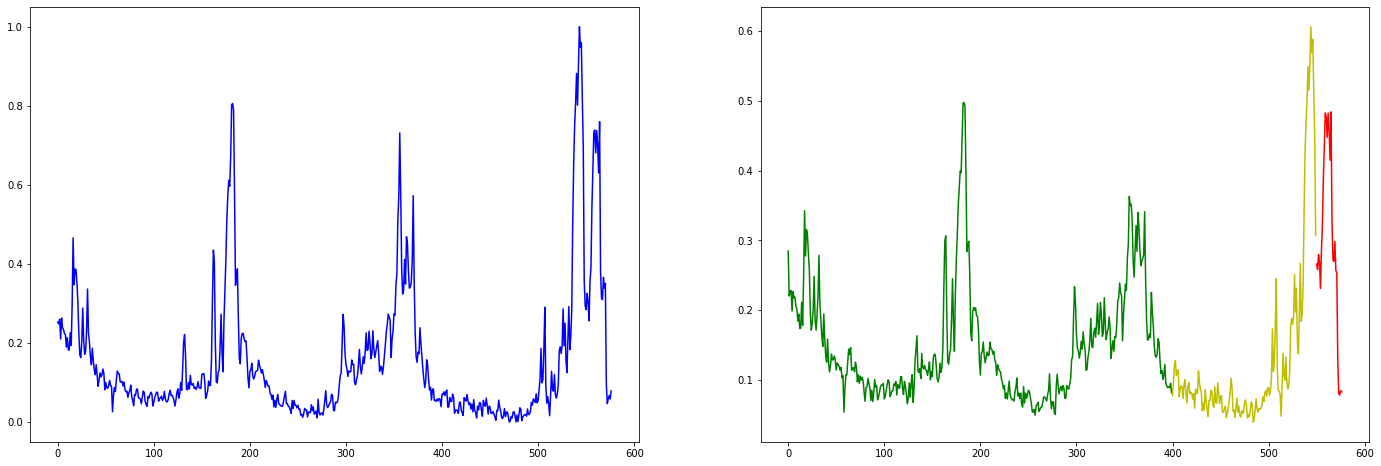

In [13]:
%matplotlib inline
plt.figure(figsize=(24,8))
train_predict = model1.predict(train_X)
valid_predict = model1.predict(valid_X)
test_predict = model1.predict(test_X)
train_predict = train_predict.flatten()
valid_predict = valid_predict.flatten()
test_predict = test_predict.flatten()


plt.subplot(121)
plt.plot(values[:, -1], c='b')
plt.subplot(122)
plt.plot([x for x in train_predict], c='g')
plt.plot([None for _ in train_predict] + [x for x in valid_predict], c='y')
plt.plot([None for _ in train_predict] + [None for _ in valid_predict] + [x for x in test_predict], c='r')
plt.show()